# Prediction of Annual Return from Fundamental Data and Market Cap
Chapter 4 of the book: "Build Your Own AI Investor"

For our investing AI to select stocks for investment it will need to be able to predict which stocks are likely to go up. WIth our X and y data we can train any of the machine learning algorithms to do this. We'll try using all of them and keep the ones that show promise.

In [1]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

In [2]:
from platform import python_version
print(python_version())

3.7.7


### Imports and Getting Our Data

In [229]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
from pandas.plotting import scatter_matrix

In [230]:
# Read in data
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
y=y["Perf"]

In [231]:
y.mean()

0.1547043809519322

# Linear Regression
As a start try vanilla linear regression to get the ball rolling.
We use the powertransformer in a pipeline with our linear regressor.

In [232]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

# Save CSVs incase want to see the data.
# X_train.to_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv")
# X_test.to_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv")
# y_train.to_csv("Annual_Stock_Price_Performance_Percentage_train.csv")
# y_test.to_csv("Annual_Stock_Price_Performance_Percentage_test.csv")

X training matrix dimensions:  (10879, 18)
X testing matrix dimensions:  (1209, 18)
y training matrix dimensions:  (10879,)
y testing matrix dimensions:  (1209,)


In [233]:
# Linear
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

pl_linear = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('linear', LinearRegression())
])
pl_linear.fit(X_train, y_train)
y_pred = pl_linear.predict(X_test)
print('train mse: ', mean_squared_error(y_train, pl_linear.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))


import pickle # To save the fitted model
pickle.dump(pl_linear, open("pl_linear.p", "wb" ))

train mse:  0.4029881962472862
test mse:  0.3040377887294661


It appears to work, Great!
We aren't so sure about how big the train/test split should be. 

### Linear Regression K fold Cross Validation

We can use K-Fold cross validation to try a few testing set sizes(the more folds used, the smaller the testing set), and get to see the consistency of our prediciton results too.

In [99]:
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Try a few values of K, show results.
vals=[2,5,10,50,100,200]

for i in vals:
    scores = cross_validate(pl_linear, x, y, scoring='neg_mean_squared_error', cv=i, return_train_score=True)
    print('K=', i,'Segments')
    
    #print('Train scores',np.sqrt(-scores['train_score']))
    #print('Test scores',np.sqrt(-scores['test_score']))
    
    print('AVERAGE TEST SCORE:',\
          round(np.sqrt(-scores['test_score']).mean(),4),\
         'STD. DEV.:', round(np.sqrt(-scores['test_score']).std(),4))
    
    print('AVERAGE TRAIN SCORE:',\
          round(np.sqrt(-scores['train_score']).mean(),4),\
         'STD. DEV.:', round(np.sqrt(-scores['train_score']).std(),4))
    
    print('-----------------')
    

K= 2 Segments
AVERAGE TEST SCORE: 0.622 STD. DEV.: 0.0927
AVERAGE TRAIN SCORE: 0.6194 STD. DEV.: 0.0933
-----------------
K= 5 Segments
AVERAGE TEST SCORE: 0.6136 STD. DEV.: 0.1384
AVERAGE TRAIN SCORE: 0.6254 STD. DEV.: 0.0411
-----------------
K= 10 Segments
AVERAGE TEST SCORE: 0.5994 STD. DEV.: 0.1905
AVERAGE TRAIN SCORE: 0.6261 STD. DEV.: 0.0301
-----------------
K= 50 Segments
AVERAGE TEST SCORE: 0.5558 STD. DEV.: 0.2949
AVERAGE TRAIN SCORE: 0.6268 STD. DEV.: 0.0134
-----------------
K= 100 Segments
AVERAGE TEST SCORE: 0.5422 STD. DEV.: 0.3188
AVERAGE TRAIN SCORE: 0.6269 STD. DEV.: 0.0071
-----------------
K= 200 Segments
AVERAGE TEST SCORE: 0.5173 STD. DEV.: 0.3594
AVERAGE TRAIN SCORE: 0.6269 STD. DEV.: 0.0051
-----------------


### Linear Regression Prediction Analysis
Looks like smaller test set sizes increase the accuracy, but also increase the variation. As the variation is quite high we will want to use a reasonably large test size to be able to discern its predictive ability. Using k=10(Test size of 0.1) is a good compromise, so we will use that going forward. Let's see how good our predictions are in a bit more depth. Our AI will be depending on these predictions so we need to be sure stocks can be picked well here.

#### Plotting Function
To get a better view of how good the predictions are(visually) without depending on mean squared error.

In [234]:
# Output scatter plot and contour plot of density of points to see if prediciton matches reality
# Line of x=y is provided, perfect prediction would have all density on this line
# Also plot linear regression of the scatter

# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plotDensityContourPredVsReal(model_name, x_plot, y_plot, ps):
    # Plotting scatter 
    plt.scatter(x_plot, y_plot, s=1)
    # Plotting linear regression
    # Swap X and Y fit because prediction is quite centered around one value.
    LinMod = LinearRegression().fit(y_plot.reshape(-1, 1), x_plot.reshape(-1, 1))
    xx=[[-5],[5]]
    yy=LinMod.predict(xx)
    plt.plot(yy,xx,'g')
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Predicted Return')
    plt.ylabel('Actual Return')
    plt.plot([-100,100],[-100,100],'y--')
    plt.xlim([-ps,ps])
    plt.ylim([-ps,ps])
    plt.title('Predicted/Actual density plot for {}'.format(model_name))
    plt.legend(['Linear Fit Line','y=x Perfect Prediction Line','Prediction Points'])
    # Save Figure
    #plt.figure(figsize=(5,5))
    plt.savefig('result.png')

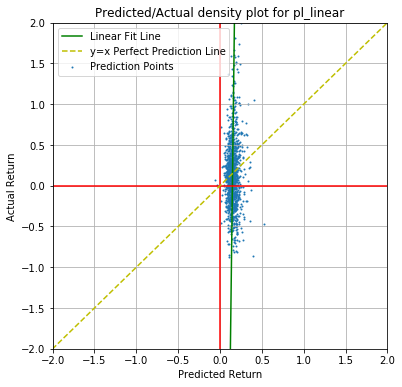

In [235]:
plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_linear', y_pred, y_test.to_numpy(), 2)

It doesn't look so good visually, but there seems to be some ability there. Let's take a closer look by taking our predictors top 10 stock return predictions and comparing them to reality.

In [236]:
# See top 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_top10 = (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0]) # Top 10 predicted returns
y_test_reindexed=y_test.reset_index(drop=True)

print('Predicted Returns:',y_predtest[bl_top10][0].values)
print('Actual Returns:', y_test_reindexed[bl_top10].values)
print('Top 10 Predicted Returns:', round( np.mean(y_predtest[bl_top10][0])*100,2 ), '%','\n')
print('Actual Top 10 Returns:', round( np.mean(y_test_reindexed[bl_top10])*100,2 ), '%')

Predicted Returns: [0.34250406 0.36809282 0.39072937 0.53179046 0.40934295 0.34037619
 0.35651908 0.35353655 0.36441244]
Actual Returns: [ 0.21407837 -0.05194805 -0.86666667 -0.46698644  1.05479452  3.36976744
  0.22739153 -0.42782152  0.2855831 ]
Top 10 Predicted Returns: 38.41 % 

Actual Top 10 Returns: 37.09 %


Seems there is something to this. Let's try the bottom 10.

In [237]:
# See bottom 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_bottom10 = (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])

#print('Returns:',y_predtest[bl_bottom10][0].values)
#print('Returns:',y_test_reindexed[bl_bottom10].values)
print('Bottom 10 Predicted Returns:', round( np.mean(y_predtest[bl_bottom10][0])*100,2 ), '%','\n')
print('Actual Bottom 10 Returns:', round( np.mean(y_test_reindexed[bl_bottom10])*100,2 ), '%')

Bottom 10 Predicted Returns: 0.84 % 

Actual Bottom 10 Returns: 4.88 %


There is *some* predictive ability here, it is definately worthwhile using linear regression in the backtest under greater scrutiny later. Don't worry about survivorship bias at this point, we can account for that later, besides these predicted returns are high enough to compensate for that if you look at bankruptcy statistics, and the kinds of stocks being chosen.

Let's try the model with a few more train/test samplings by changing the random_state, and see if the predictive ability stays.

### Try a few Linear Regression runs and see if the top/bottom 10 selections are any good.

In [145]:
# Create table of top10/bottom 10 averaged, 10 rows of 10 random_states.
def observePredictionAbility(my_pipeline):
    Top10PredRtrns=np.array([])
    Top10ActRtrns=np.array([])
    Bottom10PredRtrns=np.array([])
    Bottom10ActRtrns=np.array([])

    for i in range (0,10):
        
        X_train, X_test, y_train, y_test = \
        train_test_split(x, y, test_size=0.1, random_state=i)
        
        my_pipeline.fit(X_train, y_train)
        y_pred = my_pipeline.predict(X_test)
        
        # See top 10 stocks and see how the values differ
        y_predtest=pd.DataFrame(y_pred)
        bl_top10 = \
        (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
        
        y_test_reindexed=y_test.reset_index(drop=True)
        
        Top10PredRtrns = np.append(Top10PredRtrns,\
                round( np.mean(y_predtest[bl_top10][0])*100,2 ))
        Top10ActRtrns = np.append(Top10ActRtrns,\
                round( np.mean(y_test_reindexed[bl_top10])*100,2 ))
        
        # See bottom 10 stocks and see how the values differ
        y_predtest=pd.DataFrame(y_pred)
        bl_bottom10 =\
        (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])
        
        #print('Returns:',y_predtest[bl_bottom10][0].values)
        Bottom10PredRtrns = np.append(Bottom10PredRtrns,\
                round( np.mean(y_predtest[bl_bottom10][0])*100,2 ))
        #print('Returns:',y_test_reindexed[bl_bottom10].values)
        Bottom10ActRtrns = np.append( Bottom10ActRtrns,\
                round(np.mean(y_test_reindexed[bl_bottom10])*100,2 ))

    
    print('Predicted Performance of Top 10 Return Portfolios:', Top10PredRtrns)
    print('Actual Performance of Top 10 Return Portfolios:', Top10ActRtrns,'\n')
    print('Predicted Performance of Bottom 10 Return Portfolios:', Bottom10PredRtrns)
    print('Actual Performance of Bottom 10 Return Portfolios:', Bottom10ActRtrns)
    
    print('--------------\n')
    
    print('Mean Predicted Std. Dev. of Top 10 Return Portfolios:',round(Top10PredRtrns.std(),2))
    print('Mean Actual Std. Dev. of Top 10 Return Portfolios:',round(Top10ActRtrns.std(),2))
    print('Mean Predicted Std. Dev. of Bottom 10 Return Portfolios:',round(Bottom10PredRtrns.std(),2))
    print('Mean Actual Std. Dev. of Bottom 10 Return Portfolios:',round(Bottom10ActRtrns.std(),2))

    print('--------------\n')
    #IMPORT PERFORMANCE MEASURES HERE
    print(\
      '\033[4mMean Predicted Performance of Top 10 Return Portfolios:\033[0m',\
          round(Top10PredRtrns.mean(),2))
    print(\
      '\033[4mMean Actual Performance of Top 10 Return Portfolios:\033[0m',\
          round(Top10ActRtrns.mean(),2))
    print('Mean Predicted Performance of Bottom 10 Return Portfolios:',\
          round(Bottom10PredRtrns.mean(),2))
    print('Mean Actual Performance of Bottom 10 Return Portfolios:',\
          round(Bottom10ActRtrns.mean(),2))

    print('--------------\n')
    
observePredictionAbility(pl_linear)

Predicted Performance of Top 10 Return Portfolios: [41.21 39.8  32.99 42.11 48.27 36.75 38.19 34.74 49.67 51.47]
Actual Performance of Top 10 Return Portfolios: [ 37.36 105.98 240.67  -4.    13.2   40.39  98.95 202.92 -27.53   7.41] 

Predicted Performance of Bottom 10 Return Portfolios: [0.79 3.06 1.96 2.4  1.34 3.42 2.21 2.83 2.03 3.96]
Actual Performance of Bottom 10 Return Portfolios: [20.18 -3.1  13.12 43.85 -3.07 14.23  0.23 25.51 18.58 14.83]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 6.06
Mean Actual Std. Dev. of Top 10 Return Portfolios: 85.43
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 0.9
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 13.62
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 41.52
Mean Actual Performance of Top 10 Return Portfolios: 71.54
Mean Predicted Performance of Bottom 10 Return Portfolios: 2.4
Mean Actual Performance of Bottom 10 Return Portfolios: 14.44
--------------



# Elastic Net Regression
Let's see if some regularisation form linear regression will get us better results.

In [147]:
# ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PowerTransformer

pl_ElasticNet = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet())#l1_ratio=0.00001, alpha=0.001
])

pl_ElasticNet.fit(X_train, y_train)
y_pred = pl_ElasticNet.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_ElasticNet.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, pl_ElasticNet.predict(X_test)))

import pickle
pickle.dump(pl_ElasticNet, open("pl_ElasticNet.p", "wb" ))



train mse:  0.4058427634834169
test mse:  0.30862054850787846


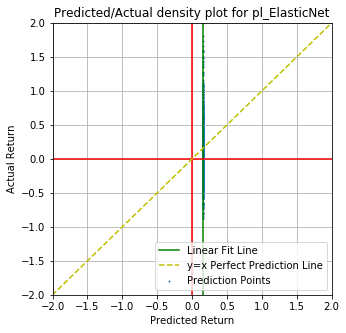

In [148]:
plt.figure(figsize=(5,5))
plotDensityContourPredVsReal('pl_ElasticNet', y_pred, y_test.to_numpy(),2)

### Test some Hyperparameters to try and improve prediction

In [149]:
# ElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PowerTransformer

pl_ElasticNet = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet(l1_ratio=0.00001))
])

pl_ElasticNet.fit(X_train, y_train)
y_pred_lowL1 = pl_ElasticNet.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_ElasticNet.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, pl_ElasticNet.predict(X_test)))

import pickle
pickle.dump(pl_ElasticNet, open("pl_ElasticNet.p", "wb" ))



train mse:  0.4041274356401521
test mse:  0.30607580983694965


Text(0.5, 1, 'Elasticnet L1 Ratio=0.00001')

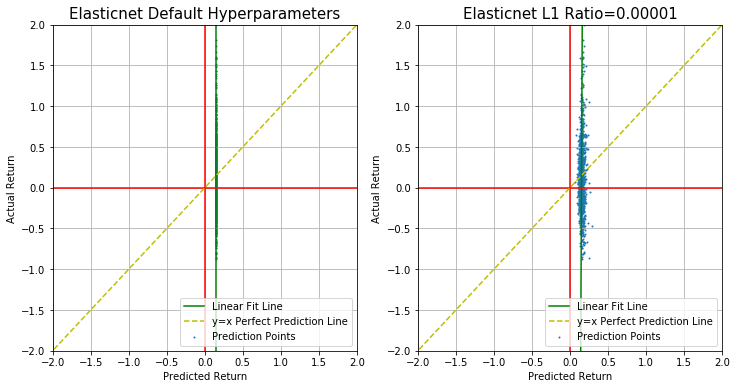

In [150]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plotDensityContourPredVsReal('pl_ElasticNet', y_pred, y_test.to_numpy(),2)
plt.title('Elasticnet Default Hyperparameters',fontsize=15)
plt.subplot(1,2,2)
plotDensityContourPredVsReal('pl_ElasticNet', y_pred_lowL1, y_test.to_numpy(),2)
plt.title('Elasticnet L1 Ratio=0.00001',fontsize=15)

In [151]:
# See top 10 stocks and see how the values differ for Low L1 case
y_predtest=pd.DataFrame(y_pred_lowL1)
bl_top10 = (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
y_test_reindexed=y_test.reset_index(drop=True)

#print('Returns:',y_predtest[bl_top10][0].values)
print('Top 10 Predicted Returns:', round( np.mean(y_predtest[bl_top10][0])*100,2 ), '%','\n')
#print('Returns:', y_test_reindexed[bl_top10].values)
print('Actual Top 10 Returns:', round( np.mean(y_test_reindexed[bl_top10])*100,2 ), '%','\n')

# See bottom 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred_lowL1)
bl_bottom10 = (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])

#print('Returns:',y_predtest[bl_bottom10][0].values)
print('Bottom 10 Predicted Returns:', round( np.mean(y_predtest[bl_bottom10][0])*100,2 ), '%','\n')
#print('Returns:',y_test_reindexed[bl_bottom10].values)
print('Actual Bottom 10 Returns:', round( np.mean(y_test_reindexed[bl_bottom10])*100,2 ), '%')

Top 10 Predicted Returns: 25.12 % 

Actual Top 10 Returns: 42.08 % 

Bottom 10 Predicted Returns: 9.06 % 

Actual Bottom 10 Returns: 25.78 %


### See if the results are repeatable.

In [152]:
observePredictionAbility(pl_ElasticNet)

Predicted Performance of Top 10 Return Portfolios: [27.12 25.47 23.23 28.21 29.15 24.89 25.21 24.13 30.12 29.28]
Actual Performance of Top 10 Return Portfolios: [  7.27  64.43 221.18 -11.37  27.84  45.57  55.09 207.43 -29.51  -4.55] 

Predicted Performance of Bottom 10 Return Portfolios: [7.89 8.77 9.96 7.8  9.32 9.39 9.15 9.54 8.73 8.9 ]
Actual Performance of Bottom 10 Return Portfolios: [25.21  9.7  13.42 38.93  6.   17.64  1.96 33.68 21.09 13.45]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 2.29
Mean Actual Std. Dev. of Top 10 Return Portfolios: 83.08
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 0.65
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 11.21
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 26.68
Mean Actual Performance of Top 10 Return Portfolios: 58.34
Mean Predicted Performance of Bottom 10 Return Portfolios: 8.94
Mean Actual Performance of Bottom 10 Return Portfolios: 18.11
--------------



# K Nearest Neighbours Regression

In [153]:
# Read in data and do train/test split.
from sklearn.model_selection import train_test_split
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
y=y["Perf"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (10879, 18)
X testing matrix dimensions:  (1209, 18)
y training matrix dimensions:  (10879,)
y testing matrix dimensions:  (1209,)


In [220]:
# KNeighbors regressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer
pl_KNeighbors = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))
])

pl_KNeighbors.fit(X_train, y_train)
y_pred = pl_KNeighbors.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_KNeighbors.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_KNeighbors, open("pl_KNeighbors.p", "wb" ))



train mse:  0.3907707658880228
test mse:  0.30775430494312667


### Take a look at learning curves

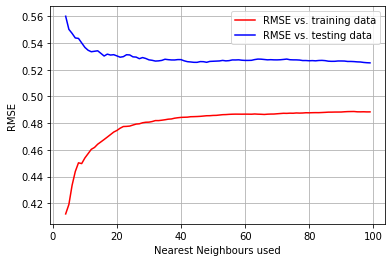

In [20]:
train_errors, test_errors, test_sizes=[], [], []

for i in range(4,100):
    pl_KNeighbors = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=i))])
    pl_KNeighbors.fit(X_train, y_train)
    y_pred = pl_KNeighbors.predict(X_test)
    train_errors.append(mean_squared_error(y_train, pl_KNeighbors.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, y_pred))
    test_sizes.append(i)

plt.plot(test_sizes, np.sqrt(train_errors),'r',test_sizes, np.sqrt(test_errors),'b')
plt.legend(['RMSE vs. training data','RMSE vs. testing data'])
plt.grid()
#plt.ylim([0,0.6])
plt.ylabel('RMSE');
plt.xlabel('Nearest Neighbours used');

### Plot the Scatter Graph
See if there is any predictive capability

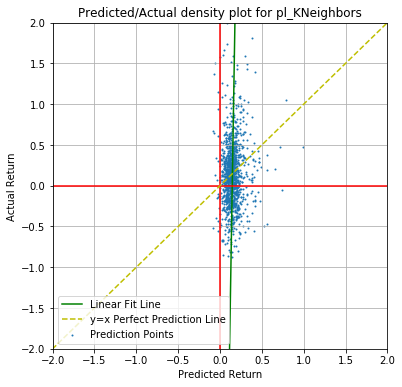

In [156]:
plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_KNeighbors', y_pred, y_test.to_numpy(),2)

Let's take a better look at the scatter graph data. Plotting a kernel density estimator contour over the top

### Investigate predictive ability

In [157]:
# See top 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_top10 = (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
y_test_reindexed=y_test.reset_index(drop=True)

#print('Returns:',y_predtest[bl_top10][0].values)
print('Top 10 Predicted Returns:', round( np.mean(y_predtest[bl_top10][0])*100,2 ), '%','\n')
#print('Returns:', y_test_reindexed[bl_top10].values)
print('Actual Top 10 Returns:', round( np.mean(y_test_reindexed[bl_top10])*100,2 ), '%','\n')

# See bottom 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_bottom10 = (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])

#print('Returns:',y_predtest[bl_bottom10][0].values)
print('Bottom 10 Predicted Returns:', round( np.mean(y_predtest[bl_bottom10][0])*100,2 ), '%','\n')
#print('Returns:',y_test_reindexed[bl_bottom10].values)
print('Actual Bottom 10 Returns:', round( np.mean(y_test_reindexed[bl_bottom10])*100,2 ), '%')

Top 10 Predicted Returns: 67.82 % 

Actual Top 10 Returns: 19.6 % 

Bottom 10 Predicted Returns: -6.04 % 

Actual Bottom 10 Returns: 39.86 %


In [158]:
observePredictionAbility(pl_KNeighbors)

Predicted Performance of Top 10 Return Portfolios: [63.26 96.35 60.16 88.21 78.83 83.66 71.75 67.53 82.56 87.31]
Actual Performance of Top 10 Return Portfolios: [  6.25  28.17 266.48   3.67  26.47  75.06  26.89 225.53  -0.29 -27.64] 

Predicted Performance of Bottom 10 Return Portfolios: [-3.88 -6.33 -6.73 -6.2  -9.09 -4.91 -7.97 -4.66 -6.59 -4.68]
Actual Performance of Bottom 10 Return Portfolios: [  6.45  21.56  39.86  36.41   4.69 -17.36  14.42  36.39  34.28   9.51]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 11.25
Mean Actual Std. Dev. of Top 10 Return Portfolios: 95.28
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 1.54
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 17.53
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 77.96
Mean Actual Performance of Top 10 Return Portfolios: 63.06
Mean Predicted Performance of Bottom 10 Return Portfolios: -6.1
Mean Actual Performance of Bottom 10 Return Portfolios: 18.62
--------

### Investigate predictive ability with KDE plot

In [221]:
# Output scatter plot and contour plot of density of points to see if prediciton matches reality
# Line of x=y is provided, perfect prediction would have all density on this line
# Also plot linear regression of the scatter

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde # Need for Kernel Density Calculation
from sklearn.linear_model import LinearRegression

def plotDensityContourPredVsRealContour(model_name, x_plot, y_plot, ps):
#x_plot, y_plot = y_pred, y_test.to_numpy()
    resolution = 40
    # Make a gaussian kde on a grid
    k = kde.gaussian_kde(np.stack([x_plot,y_plot]))
    xi, yi = np.mgrid[-ps:ps:resolution*4j, -ps:ps:resolution*4j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # Plotting scatter and contour plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Greens)
    plt.contour(xi, yi, zi.reshape(xi.shape) )
    plt.scatter(x_plot, y_plot, s=1)
    # Plotting linear regression
    LinMod = LinearRegression()
    LinMod.fit(y_plot.reshape(-1, 1), x_plot.reshape(-1, 1),)
    xx=[[-2],[2]]
    yy=LinMod.predict(xx)
    plt.plot(yy,xx)
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Predicted Return')
    plt.ylabel('Actual Return')
    plt.plot([-100,100],[-100,100],'y--')
    plt.xlim([-ps*0.2,ps*0.6]) #
    plt.ylim([-ps,ps])
    plt.title('Predicted/Actual density plot for {}'.format(model_name))
    plt.legend(['Linear Fit Line','y=x Perfect Prediction Line','Prediction Points'])
    # Save Figure
    #plt.savefig('result.png')

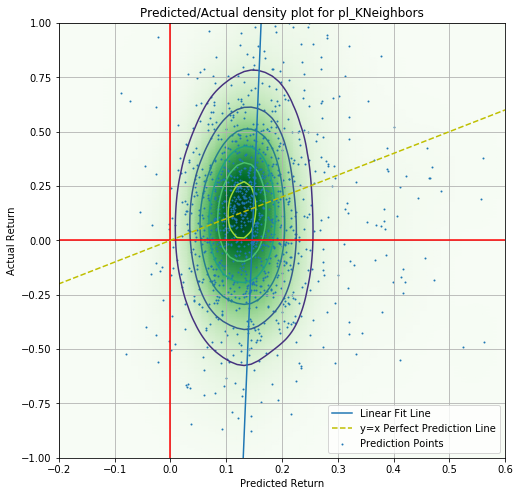

In [222]:
plt.figure(figsize=(8,8))
plotDensityContourPredVsRealContour('pl_KNeighbors', y_pred, y_test.to_numpy(),1)

# Support Vector Machine Regression
### Quick SVM Regressor with default parameters

In [224]:
# Read in data and do train/test split.
from sklearn.model_selection import train_test_split
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
y=y["Perf"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (10879, 18)
X testing matrix dimensions:  (1209, 18)
y training matrix dimensions:  (10879,)
y testing matrix dimensions:  (1209,)


In [225]:
# SVM quick and dirty
from sklearn.svm import SVR

pl_svm = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('SVR', SVR()) # kernel='rbf', C=100, gamma=0.1, epsilon=.1 generated good returns. 
])

pl_svm.fit(X_train, y_train)
y_pred = pl_svm.predict(X_test)
from sklearn.metrics import mean_squared_error
print('mse: ', mean_squared_error(y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print('mae: ', mean_absolute_error(y_test, y_pred))

import pickle
pickle.dump(pl_svm, open("pl_svm.p", "wb" ))

mse:  0.3316924011042412
mae:  0.3260140864681771


In [226]:
observePredictionAbility(pl_svm)

Predicted Performance of Top 10 Return Portfolios: [66.97 60.24 47.28 49.83 65.41 54.57 57.15 60.62 52.7  52.68]
Actual Performance of Top 10 Return Portfolios: [18.03 98.26 43.03  9.08 20.38 77.17 20.37 77.78  9.56 24.94] 

Predicted Performance of Bottom 10 Return Portfolios: [-41.73 -33.76 -42.98 -42.77 -37.87 -43.1  -46.65 -41.03 -48.69 -47.07]
Actual Performance of Bottom 10 Return Portfolios: [ 18.72  56.04  37.71  58.89  18.45  -4.26 -11.63  13.22 -30.26  63.43]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 6.18
Mean Actual Std. Dev. of Top 10 Return Portfolios: 30.94
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 4.21
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 30.22
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 56.74
Mean Actual Performance of Top 10 Return Portfolios: 39.86
Mean Predicted Performance of Bottom 10 Return Portfolios: -42.56
Mean Actual Performance of Bottom 10 Return Portfolios: 22.03
-------

### As there are many parameters do a GridSearch CV, to find optimal parameters
We aren't actually aiming for prediction ACCURACY though. SKip this part in the book.

In [13]:
# Takes a LONG time
from sklearn.model_selection import GridSearchCV

parameters = [{'SVR__kernel': ['linear'],\
               'SVR__C': [1, 10, 100],\
               'SVR__epsilon': [0.05, 0.1, 0.2]},\
                {'SVR__kernel': ['rbf'],\
               'SVR__C': [1, 10, 100],\
               'SVR__gamma': [0.001, 0.01, 0.1],\
               'SVR__epsilon': [0.05, 0.1, 0.2]} ] # Best found was C=1, gamma=0.001, epsilon=0.2

svm_gs = GridSearchCV(pl_svm, parameters, cv=10, scoring='neg_mean_squared_error')

svm_gs.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(svm_gs.best_params_,'\n')
print("Grid scores on development set:")
means = svm_gs.cv_results_['mean_test_score']
stds = svm_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svm_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
{'SVR__C': 1, 'SVR__epsilon': 0.2, 'SVR__gamma': 0.001, 'SVR__kernel': 'rbf'} 

Grid scores on development set:
-0.251 (+/-0.200) for {'SVR__C': 1, 'SVR__epsilon': 0.05, 'SVR__kernel': 'linear'}
-0.249 (+/-0.199) for {'SVR__C': 1, 'SVR__epsilon': 0.1, 'SVR__kernel': 'linear'}
-0.248 (+/-0.198) for {'SVR__C': 1, 'SVR__epsilon': 0.2, 'SVR__kernel': 'linear'}
-0.251 (+/-0.200) for {'SVR__C': 10, 'SVR__epsilon': 0.05, 'SVR__kernel': 'linear'}
-0.249 (+/-0.199) for {'SVR__C': 10, 'SVR__epsilon': 0.1, 'SVR__kernel': 'linear'}
-0.248 (+/-0.198) for {'SVR__C': 10, 'SVR__epsilon': 0.2, 'SVR__kernel': 'linear'}
-0.251 (+/-0.200) for {'SVR__C': 100, 'SVR__epsilon': 0.05, 'SVR__kernel': 'linear'}
-0.249 (+/-0.199) for {'SVR__C': 100, 'SVR__epsilon': 0.1, 'SVR__kernel': 'linear'}
-0.248 (+/-0.198) for {'SVR__C': 100, 'SVR__epsilon': 0.2, 'SVR__kernel': 'linear'}
-0.252 (+/-0.200) for {'SVR__C': 1, 'SVR__epsilon': 0.05, 'SVR__gamma': 0.001, 'SVR__kernel'

mse:  0.3151421223097818
mae:  0.32109748263949384


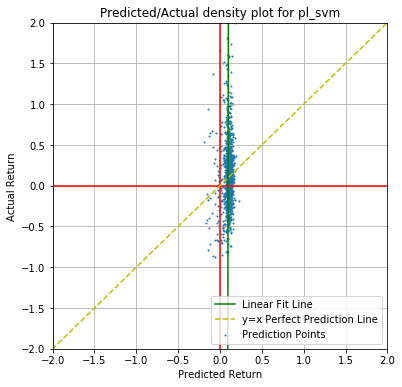

In [228]:
# SVM with (supposedly) optimal parameters
from sklearn.svm import SVR

pl_svm = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('SVR', SVR(kernel='rbf', C=1, gamma=0.001, epsilon=.2)) # Now using optimal parameters (supposedly)
])

pl_svm.fit(X_train, y_train)
y_pred = pl_svm.predict(X_test)
from sklearn.metrics import mean_squared_error
print('mse: ', mean_squared_error(y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print('mae: ', mean_absolute_error(y_test, y_pred))

import pickle
pickle.dump(pl_svm, open("pl_svm.p", "wb" ))

plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_svm', y_pred, y_test.to_numpy(), 2)

In [32]:
observePredictionAbility(pl_svm)

Predicted Performance of Top 10 Return Portfolios: [17.22 18.05 18.14 21.82 18.17 18.54 17.41 18.23 19.45 18.56 19.85]
Actual Performance of Top 10 Return Portfolios: [17.91  7.78 31.74  5.69 12.19 13.49 11.99 27.51  9.62  9.96  2.58] 

Predicted Performance of Bottom 10 Return Portfolios: [-21.85 -21.05 -19.44 -20.8  -22.99 -20.67 -19.43 -21.97 -19.02 -16.92
 -23.23]
Actual Performance of Bottom 10 Return Portfolios: [-22.62  17.04  45.56  44.08 -35.42 -25.62 -28.86 -32.99 -23.13 -13.45
   5.61]
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 18.68 , Std. Dev.: 1.23
Mean Actual Performance of Top 10 Return Portfolios: 13.68 , Std. Dev.: 8.49
Mean Predicted Performance of Bottom 10 Return Portfolios: -20.67 , Std. Dev.: 1.78
Mean Actual Performance of Bottom 10 Return Portfolios: -6.35 , Std. Dev.: 28.54
--------------


### Optimal prediction ability may not be optimal for US (Own selected parameters)
yes the prediction coulld be more accurate, but if it is producing lower returns for us then the MSE measure of error isn't really what we want, even if it might tend towards what we want.

In [244]:
# Create table of top10 averaged and average that to give us a synthetic performance result.
def getMyPredictionAbility(my_pipeline):
    Top10PredRtrns=np.array([])
    Top10ActRtrns=np.array([])
    Bottom10PredRtrns=np.array([])
    Bottom10ActRtrns=np.array([])
    for i in range (0,10):
        # Pipeline and train/test
        X_train, X_test, y_train, y_test =\
        train_test_split(x, y, test_size=0.1, random_state=i)
        my_pipeline.fit(X_train, y_train)
        y_pred = my_pipeline.predict(X_test)
        
        # See top 10 stocks and see how the values differ
        y_predtest=pd.DataFrame(y_pred)
        bl_top10=\
        (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
        y_test_reindexed=y_test.reset_index(drop=True)
        Top10PredRtrns=np.append(Top10PredRtrns,\
                    round( np.mean(y_predtest[bl_top10][0])*100,2 ))
        Top10ActRtrns=np.append(Top10ActRtrns,\
                    round( np.mean(y_test_reindexed[bl_top10])*100,2 ))
        
        # See bottom 10 stocks and see how the values differ
        y_predtest=pd.DataFrame(y_pred)
        bl_bottom10=\
        (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])
        Bottom10PredRtrns=\
        np.append(Bottom10PredRtrns,\
                  round( np.mean(y_predtest[bl_bottom10][0])*100,2 ))
        
        Bottom10ActRtrns=\
        np.append( Bottom10ActRtrns,\
                  round(np.mean(y_test_reindexed[bl_bottom10])*100,2 ))
    return round(Top10ActRtrns.mean(),2), round(Top10PredRtrns.std(),2)

In [245]:
# Iterate through possible hyperparameters and find the combination that gives best return.
# Takes a long time, only run in parallel
for kern in ['linear', 'rbf']:
    gam_val=0
    if kern == 'linear':
        for C_val in [1, 10, 100]:
            for eps_val in [0.05, 0.1, 0.2]:
                pl_svm = Pipeline([('Power Transformer', PowerTransformer()),\
                            ('SVR', SVR(kernel=kern, C=C_val, epsilon=eps_val)) ])
                performance, certainty = getMyPredictionAbility(pl_svm)
                print('return:', performance, 'std.dev.', certainty,\
                      'For Kernel:', kern, 'C:', C_val, 'Gamma:', gam_val, 'Epsilon', eps_val )
    if kern == 'rbf':
        for C_val in [1, 10, 100]:
            for eps_val in [0.05, 0.1, 0.2]:
                for gam_val in [0.001, 0.01, 0.1]:
                    pl_svm = Pipeline([('Power Transformer', PowerTransformer()),\
                                ('SVR', SVR(kernel=kern, C=C_val, gamma = gam_val, epsilon=eps_val)) ])      
                    performance, certainty = getMyPredictionAbility(pl_svm)
                    print('return:', performance, 'std.dev.', certainty,\
                          'For Kernel:', kern, 'C:', C_val, 'Gamma:', gam_val, 'Epsilon', eps_val )


return: 13.85 std.dev. 3.58 For Kernel: linear C: 1 Gamma: 0 Epsilon 0.05
return: 11.78 std.dev. 3.42 For Kernel: linear C: 1 Gamma: 0 Epsilon 0.1
return: 12.7 std.dev. 3.03 For Kernel: linear C: 1 Gamma: 0 Epsilon 0.2
return: 13.85 std.dev. 3.6 For Kernel: linear C: 10 Gamma: 0 Epsilon 0.05
return: 11.78 std.dev. 3.43 For Kernel: linear C: 10 Gamma: 0 Epsilon 0.1
return: 12.7 std.dev. 3.02 For Kernel: linear C: 10 Gamma: 0 Epsilon 0.2
return: 13.06 std.dev. 3.52 For Kernel: linear C: 100 Gamma: 0 Epsilon 0.05
return: 12.04 std.dev. 3.44 For Kernel: linear C: 100 Gamma: 0 Epsilon 0.1


KeyboardInterrupt: 

In [239]:
# SVM that gives higher stock returns.
from sklearn.svm import SVR

pl_svm = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)) # 
])

pl_svm.fit(X_train, y_train)
y_pred = pl_svm.predict(X_test)
from sklearn.metrics import mean_squared_error
print('mse: ', mean_squared_error(y_test, y_pred))
from sklearn.metrics import mean_absolute_error
print('mae: ', mean_absolute_error(y_test, y_pred))

import pickle
pickle.dump(pl_svm, open("pl_svm.p", "wb" ))

mse:  0.45356919809735347
mae:  0.41268932802888536


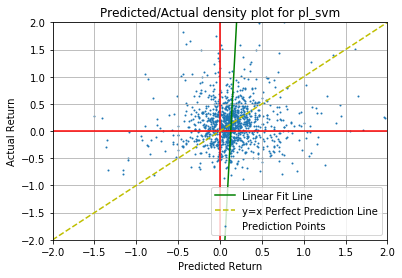

In [242]:
plotDensityContourPredVsReal('pl_svm', y_pred, y_test.to_numpy(), 2)

In [240]:
# See top 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_top10 = (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
y_test_reindexed=y_test.reset_index(drop=True)

#print('Returns:',y_predtest[bl_top10][0].values)
print('Top 10 Predicted Returns:', round( np.mean(y_predtest[bl_top10][0])*100,2 ), '%','\n')
#print('Returns:', y_test_reindexed[bl_top10].values)
print('Actual Top 10 Returns:', round( np.mean(y_test_reindexed[bl_top10])*100,2 ), '%','\n')

# See bottom 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_bottom10 = (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])

#print('Returns:',y_predtest[bl_bottom10][0].values)
print('Bottom 10 Predicted Returns:', round( np.mean(y_predtest[bl_bottom10][0])*100,2 ), '%','\n')
#print('Returns:',y_test_reindexed[bl_bottom10].values)
print('Actual Bottom 10 Returns:', round( np.mean(y_test_reindexed[bl_bottom10])*100,2 ), '%')

Top 10 Predicted Returns: 206.39 % 

Actual Top 10 Returns: -5.48 % 

Bottom 10 Predicted Returns: -171.95 % 

Actual Bottom 10 Returns: 23.15 %


In [241]:
observePredictionAbility(pl_svm)

Predicted Performance of Top 10 Return Portfolios: [241.74 279.7  276.43 216.47 255.39 434.84 287.08 250.62 258.01 375.08]
Actual Performance of Top 10 Return Portfolios: [ 28.79 101.19 234.25   8.67  -4.4   60.41  28.72  69.42 -11.73  49.09] 

Predicted Performance of Bottom 10 Return Portfolios: [-150.3  -174.32 -174.82 -136.61 -208.44 -132.04 -172.3  -154.06 -137.69
 -154.21]
Actual Performance of Bottom 10 Return Portfolios: [ 10.68 -16.32 -13.79   6.98  -1.33 -11.49  24.12  18.93  -6.48 -21.06]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 63.22
Mean Actual Std. Dev. of Top 10 Return Portfolios: 67.84
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 22.16
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 14.73
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 287.54
Mean Actual Performance of Top 10 Return Portfolios: 56.44
Mean Predicted Performance of Bottom 10 Return Portfolios: -159.48
Mean Actual Performance of Bottom 

# Decision Tree Regression

In [262]:
# Read in data and do train/test split.
from sklearn.model_selection import train_test_split
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
y=y["Perf"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (10879, 18)
X testing matrix dimensions:  (1209, 18)
y training matrix dimensions:  (10879,)
y testing matrix dimensions:  (1209,)


In [263]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)) # no need scaler
])

pl_decTree.fit(X_train, y_train)
y_pred = pl_decTree.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_decTree.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_decTree, open("pl_decTree.p", "wb" ))

train mse:  3.2581268409258447e-10
test mse:  0.7183581821229583


That train error looks VERY low, it's likely overfitted. let's create a learning curve and find a good value for max_depth

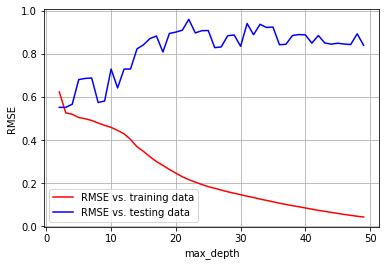

In [253]:
train_errors, test_errors, test_sizes=[], [], []

for i in range(2,50):
    pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=i))])
    pl_decTree.fit(X_train, y_train)
    y_pred = pl_decTree.predict(X_test)
    train_errors.append(mean_squared_error(y_train, pl_decTree.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, y_pred))
    test_sizes.append(i)

plt.plot(test_sizes, np.sqrt(train_errors),'r',test_sizes, np.sqrt(test_errors),'b')
plt.legend(['RMSE vs. training data','RMSE vs. testing data'])
plt.grid()
#plt.ylim([0,0.6])
plt.ylabel('RMSE');
plt.xlabel('max_depth');

We can't just choose a max_depth of 40+ because it is obviously overfitting there. The error vs. the training data is unfortunately not coming towards the error vs. testing data, so a lower tree depth is desirable, bt we can't choose a very low number, remember there are 15 columns to our x matrix (and possibly more if you have generated your own ratios).

We'll settle on a tree_depth of 10. Any less and we will obviously be utilising too little of our data, yet the error between test and training sets is reasonably close.

### Try max_depth of 5

In [289]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=8))
])

pl_decTree.fit(X_train, y_train)
y_pred = pl_decTree.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_decTree.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_decTree, open("pl_decTree.p", "wb" ))

train mse:  0.229267459811031
test mse:  0.32955636005429423


In [287]:
observePredictionAbility(pl_decTree)

Predicted Performance of Top 10 Return Portfolios: [ 273.77  262.5   419.68 1044.29  237.44  705.78  265.39  282.73  266.17
  405.64]
Actual Performance of Top 10 Return Portfolios: [ 29.21  84.45  28.26  56.52  13.17 215.16  22.78  -6.3   44.72 -11.65] 

Predicted Performance of Bottom 10 Return Portfolios: [-44.94 -44.77 -36.99 -60.23 -49.56 -47.52 -54.06 -48.76 -53.12 -53.66]
Actual Performance of Bottom 10 Return Portfolios: [ 20.99 -27.56  39.55  33.57  33.78 -19.56 -22.96 -23.36 -15.76 -51.15]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 248.48
Mean Actual Std. Dev. of Top 10 Return Portfolios: 62.01
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 6.09
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 30.41
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 416.34
Mean Actual Performance of Top 10 Return Portfolios: 47.63
Mean Predicted Performance of Bottom 10 Return Portfolios: -49.36
Mean Actual Performance of Bottom 1

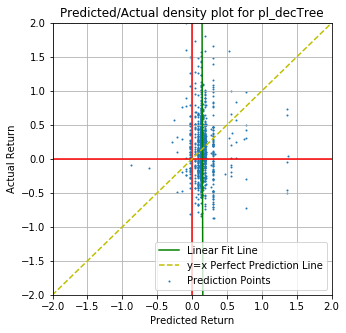

In [288]:
plt.figure(figsize=(5,5))
plotDensityContourPredVsReal('pl_decTree', y_pred, y_test.to_numpy(),2)

### K-Fold cross validation
We'll want to check how repeatable the decision tree regressor is. 

In [254]:
from sklearn.model_selection import cross_validate

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=8))])

scores = cross_validate(pl_decTree, x, y, scoring='neg_mean_squared_error', cv=10, return_train_score=True)
print('K=10 Segments.')
print('Train scores', np.round(np.sqrt(-scores['train_score']), 2) )
print('Test scores', np.round(np.sqrt(-scores['test_score']), 2) )
print('-----------------')
print('AVERAGE TEST SCORE:', round(np.sqrt(-scores['test_score']).mean(),4),\
     'STD. DEV.:', round(np.sqrt(-scores['test_score']).std(),4))
print('AVERAGE TRAIN SCORE:', round(np.sqrt(-scores['train_score']).mean(),4),\
     'STD. DEV.:', round(np.sqrt(-scores['train_score']).std(),4))
print('-----------------')

K=10 Segments.
Train scores [0.4  0.44 0.44 0.43 0.43 0.4  0.41 0.46 0.41 0.43]
Test scores [0.66 1.12 1.06 0.55 0.61 1.69 0.67 0.65 1.24 1.11]
-----------------
AVERAGE TEST SCORE: 0.9379 STD. DEV.: 0.3478
AVERAGE TRAIN SCORE: 0.4252 STD. DEV.: 0.0187
-----------------


Seems consistent, see if returns are consistent.

### Investigate Predictive Ability
What max tree depth shall we use?

In [267]:
for my_depth in [4,5,6,7,8,9,10,15,20,30,50]:
    decTree = DecisionTreeRegressor(random_state=42, max_depth=my_depth) # no need scaler
    performance, certainty = getMyPredictionAbility(decTree)
    print('Tree max_depth:', my_depth, 'Average Return:', performance,'Standard Deviation:', certainty)

Tree max_depth: 4 Average Return: nan Standard Deviation: nan
Tree max_depth: 5 Average Return: 154.61 Standard Deviation: 375.91
Tree max_depth: 6 Average Return: 58.28 Standard Deviation: 257.98
Tree max_depth: 7 Average Return: 58.0 Standard Deviation: 225.58
Tree max_depth: 8 Average Return: 47.63 Standard Deviation: 248.48
Tree max_depth: 9 Average Return: 32.21 Standard Deviation: 218.7
Tree max_depth: 10 Average Return: 36.16 Standard Deviation: 215.21
Tree max_depth: 15 Average Return: 40.74 Standard Deviation: 211.1
Tree max_depth: 20 Average Return: 34.38 Standard Deviation: 219.99
Tree max_depth: 30 Average Return: 34.44 Standard Deviation: 235.07
Tree max_depth: 50 Average Return: 32.86 Standard Deviation: 246.91


### Use max_depth of 15

In [282]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

pl_decTree = Pipeline([
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, max_depth=15))
])

pl_decTree.fit(X_train, y_train)
y_pred = pl_decTree.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_decTree.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_decTree, open("pl_decTree.p", "wb" ))

train mse:  0.12063662766294975
test mse:  0.7083490882618247


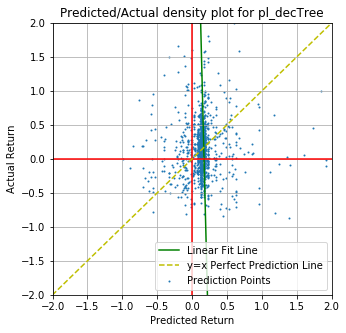

In [278]:
plt.figure(figsize=(5,5))
plotDensityContourPredVsReal('pl_decTree', y_pred, y_test.to_numpy(),2)

In [279]:
# See top 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_top10 = (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
y_test_reindexed=y_test.reset_index(drop=True)

#print('Returns:',y_predtest[bl_top10][0].values)
print('Top 10 Predicted Returns:', round( np.mean(y_predtest[bl_top10][0])*100,2 ), '%','\n')
#print('Returns:', y_test_reindexed[bl_top10].values)
print('Actual Top 10 Returns:', round( np.mean(y_test_reindexed[bl_top10])*100,2 ), '%','\n')

# See bottom 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_bottom10 = (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])

#print('Returns:',y_predtest[bl_bottom10][0].values)
print('Bottom 10 Predicted Returns:', round( np.mean(y_predtest[bl_bottom10][0])*100,2 ), '%','\n')
#print('Returns:',y_test_reindexed[bl_bottom10].values)
print('Actual Bottom 10 Returns:', round( np.mean(y_test_reindexed[bl_bottom10])*100,2 ), '%')

Top 10 Predicted Returns: 545.68 % 

Actual Top 10 Returns: 8.94 % 

Bottom 10 Predicted Returns: -79.81 % 

Actual Bottom 10 Returns: 97.58 %


In [283]:
observePredictionAbility(pl_decTree)

Predicted Performance of Top 10 Return Portfolios: [ 394.65  666.73  672.65 1035.53  683.62  843.22  461.15  349.69  362.67
  621.92]
Actual Performance of Top 10 Return Portfolios: [ 26.93  83.38  12.61  27.38  36.77 133.43  84.88  12.38   1.57 -11.97] 

Predicted Performance of Bottom 10 Return Portfolios: [-73.65 -71.03 -79.41 -90.06 -74.83 -85.21 -73.38 -80.82 -83.69 -76.06]
Actual Performance of Bottom 10 Return Portfolios: [-14.15  -2.39  19.47   7.87   6.89  -1.98 -13.11 -11.99 -27.85  41.06]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 211.1
Mean Actual Std. Dev. of Top 10 Return Portfolios: 43.19
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 5.79
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 18.64
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 609.18
Mean Actual Performance of Top 10 Return Portfolios: 40.74
Mean Predicted Performance of Bottom 10 Return Portfolios: -78.81
Mean Actual Performance of Bottom 10

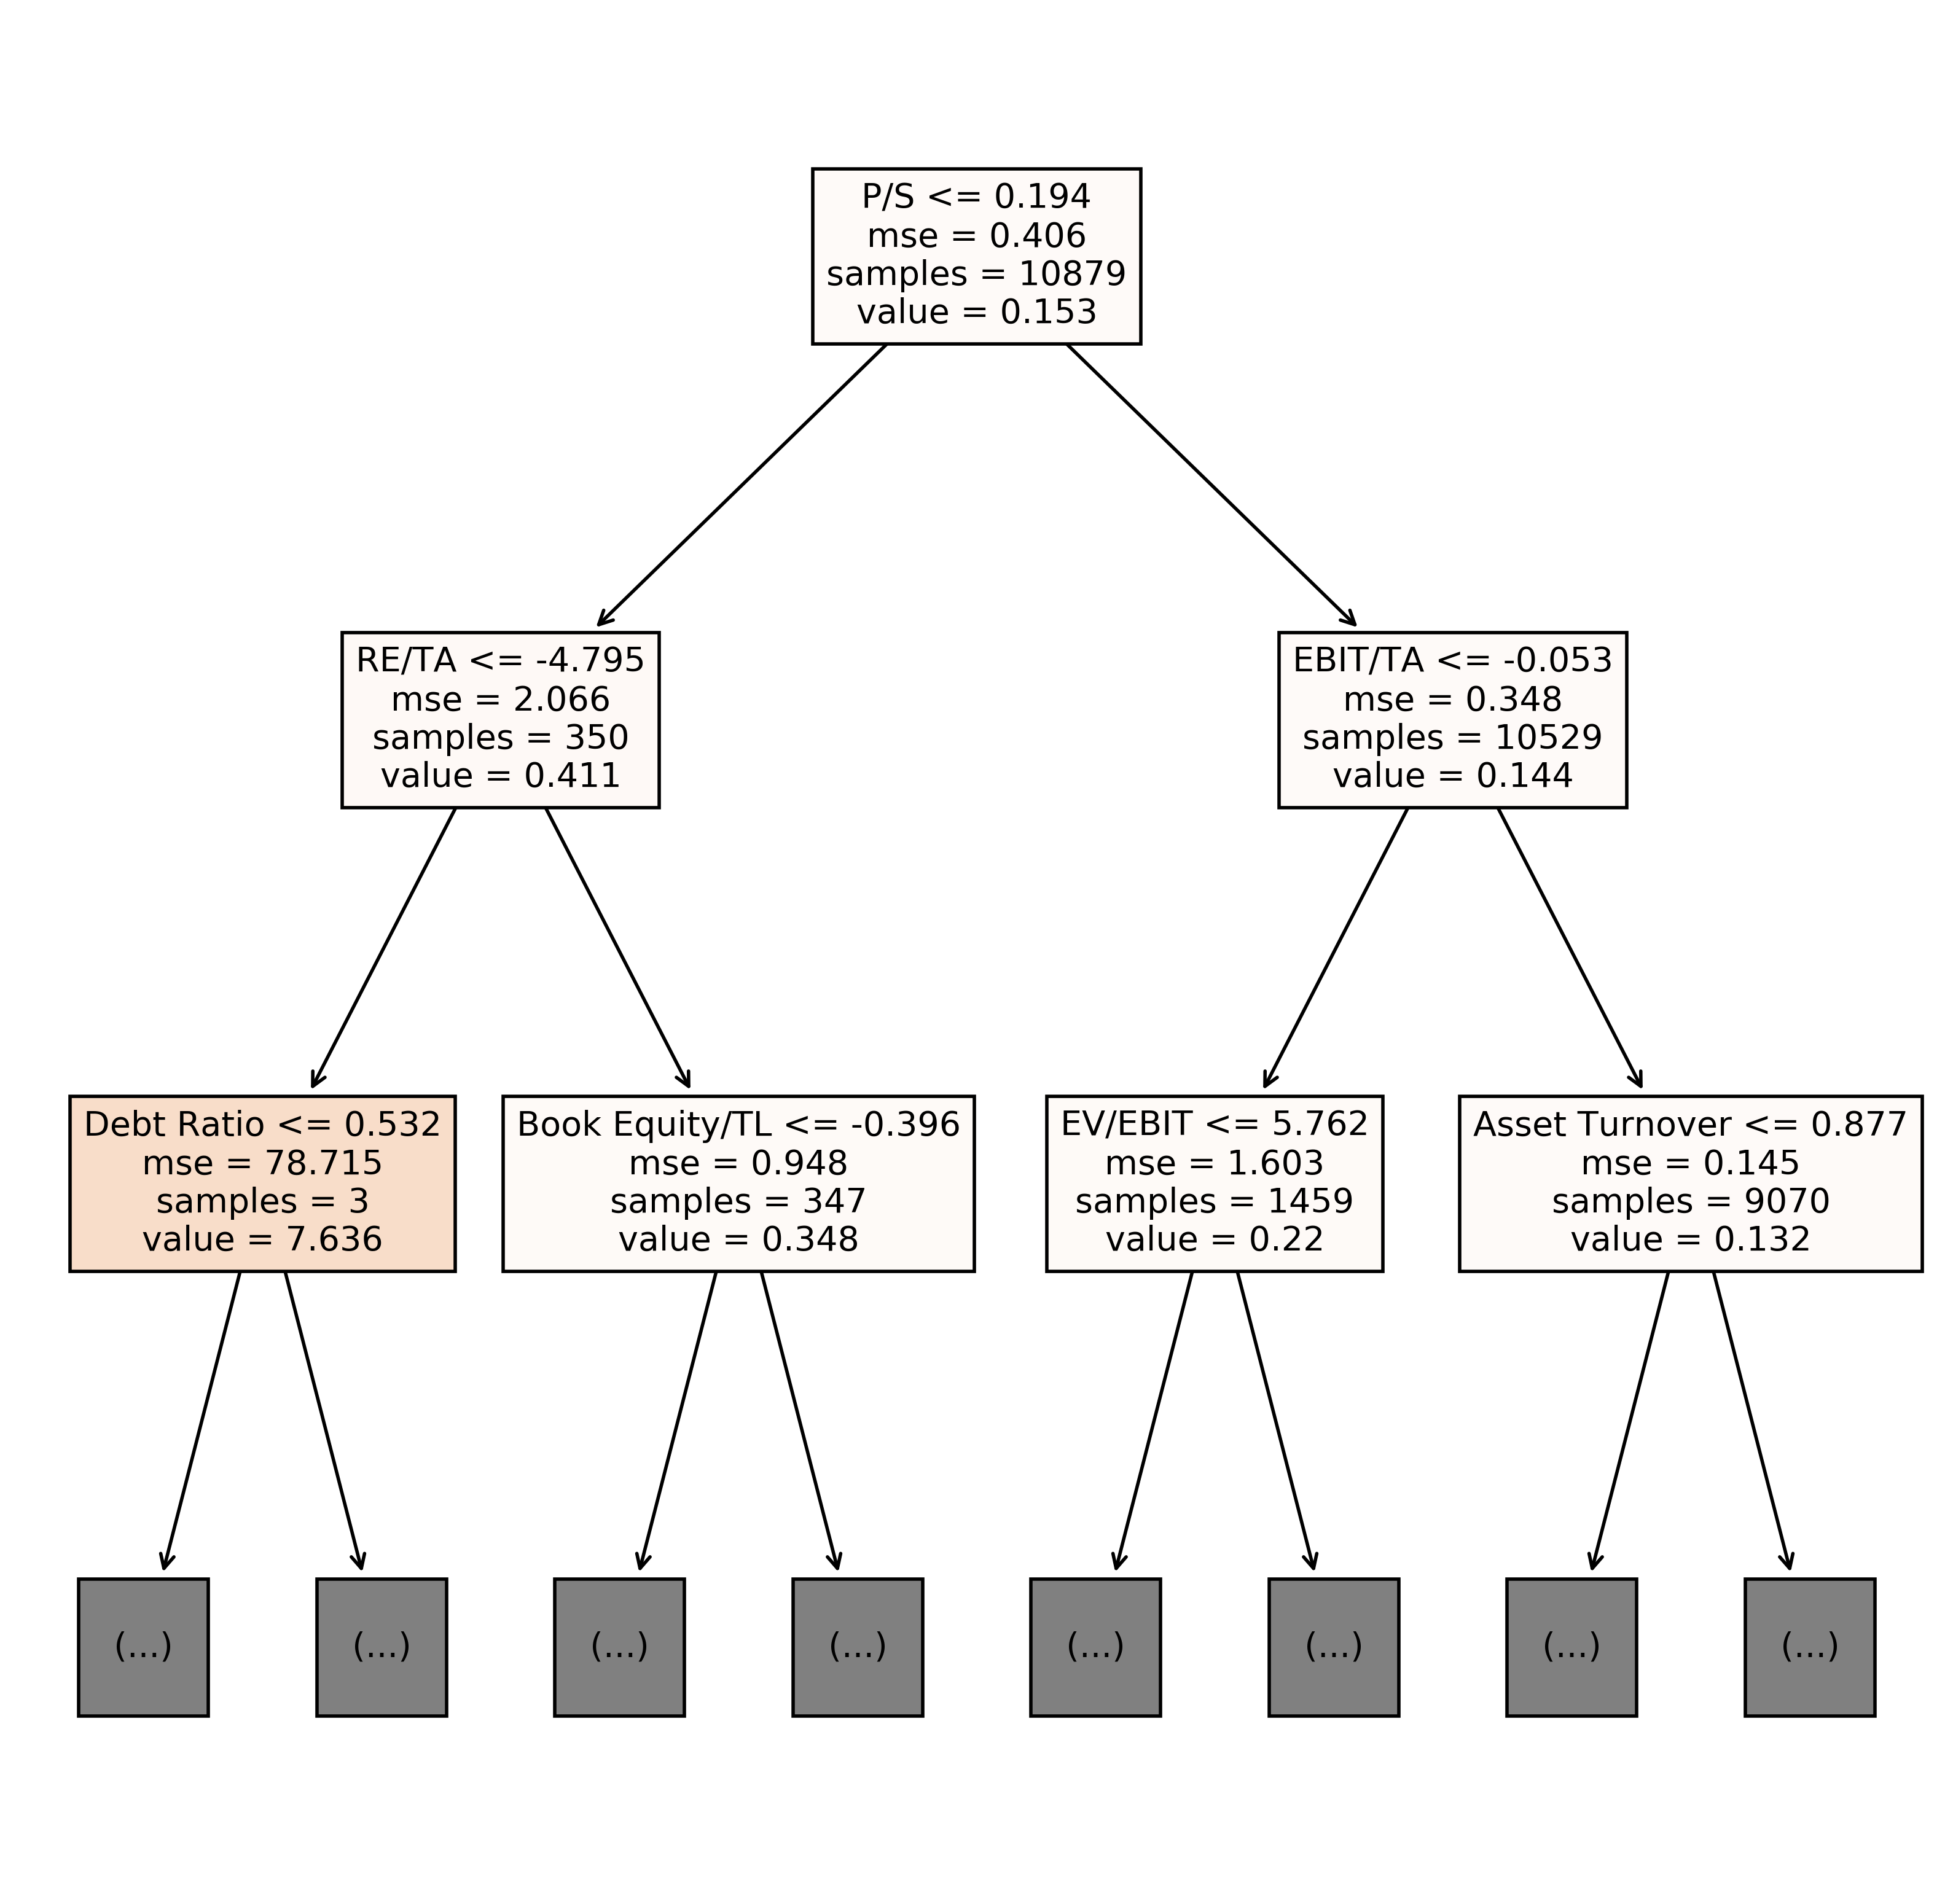

In [300]:
# See the decision tree
reg_decTree = DecisionTreeRegressor(random_state=42, max_depth=20)
reg_decTree.fit(X_train, y_train)
from sklearn import tree # Need this to see decision tree.
plt.figure(figsize=(10,10), dpi=400) # set figsize so we can see it
tree.plot_tree(reg_decTree, feature_names = x.keys(),  filled = True, max_depth=2, fontsize=10);
plt.savefig('RegDecTree.png')

# Random Forest Regression

In [303]:
# Read in data and do train/test split.
from sklearn.model_selection import train_test_split
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
y=y["Perf"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (10879, 18)
X testing matrix dimensions:  (1209, 18)
y training matrix dimensions:  (10879,)
y testing matrix dimensions:  (1209,)


In [305]:
from sklearn.ensemble import RandomForestRegressor
for my_depth in range(4,21):
    rForest = RandomForestRegressor(random_state=42, max_depth=my_depth) # no need scaler
    performance, certainty = getMyPredictionAbility(rForest)
    print('Tree max_depth:', my_depth, 'Average Return:', performance,'Standard Deviation:', certainty)

Tree max_depth: 4 Average Return: 99.09 Standard Deviation: 53.3
Tree max_depth: 5 Average Return: 92.6 Standard Deviation: 56.17
Tree max_depth: 6 Average Return: 97.49 Standard Deviation: 55.43
Tree max_depth: 7 Average Return: 97.36 Standard Deviation: 52.58
Tree max_depth: 8 Average Return: 77.03 Standard Deviation: 54.98
Tree max_depth: 9 Average Return: 65.79 Standard Deviation: 55.42
Tree max_depth: 10 Average Return: 67.37 Standard Deviation: 56.98
Tree max_depth: 11 Average Return: 71.67 Standard Deviation: 52.73
Tree max_depth: 12 Average Return: 72.42 Standard Deviation: 54.59
Tree max_depth: 13 Average Return: 75.01 Standard Deviation: 48.77
Tree max_depth: 14 Average Return: 69.78 Standard Deviation: 52.36
Tree max_depth: 15 Average Return: 69.24 Standard Deviation: 52.46
Tree max_depth: 16 Average Return: 70.98 Standard Deviation: 56.42
Tree max_depth: 17 Average Return: 47.1 Standard Deviation: 49.3
Tree max_depth: 18 Average Return: 92.04 Standard Deviation: 51.76
Tree 

In [309]:
from sklearn.ensemble import RandomForestRegressor

rfregressor = RandomForestRegressor(random_state=42, max_depth=10)

rfregressor.fit(X_train, y_train)
y_pred = rfregressor.predict(X_test)
print('train mse: ', mean_squared_error(y_train, rfregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(rfregressor, open("pl_rfregressor.p", "wb" ))

train mse:  0.20174171726931298
test mse:  0.23047971472050743


In [308]:
from sklearn.ensemble import ExtraTreesRegressor

ETregressor = ExtraTreesRegressor(random_state=42, max_depth=10)

ETregressor.fit(X_train, y_train)
y_pred_ET = ETregressor.predict(X_test)
print('train mse: ', mean_squared_error(y_train, ETregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred_ET))

import pickle
pickle.dump(ETregressor, open("pl_ETregressor.p", "wb" ))

train mse:  0.19452067362826944
test mse:  0.23343688972211674


Text(0.5, 1, 'Extra (Random) Trees Regressor')

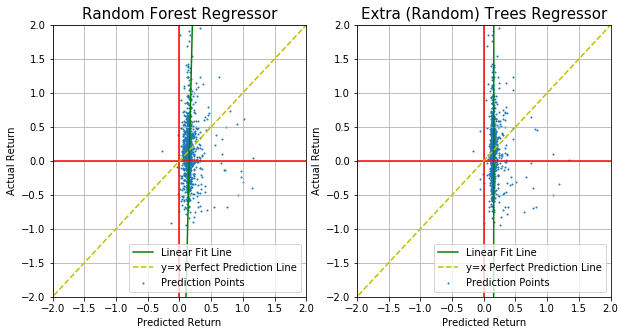

In [310]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotDensityContourPredVsReal('rfregressor', y_pred, y_test.to_numpy(),2)
plt.title('Random Forest Regressor',fontsize=15)
plt.subplot(1,2,2)
plotDensityContourPredVsReal('ETregressor', y_pred_ET, y_test.to_numpy(),2)
plt.title('Extra (Random) Trees Regressor',fontsize=15)

In [311]:
# See top 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_top10 = (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
y_test_reindexed=y_test.reset_index(drop=True)

#print('Returns:',y_predtest[bl_top10][0].values)
print('Top 10 Predicted Returns:', round( np.mean(y_predtest[bl_top10][0])*100,2 ), '%','\n')
#print('Returns:', y_test_reindexed[bl_top10].values)
print('Actual Top 10 Returns:', round( np.mean(y_test_reindexed[bl_top10])*100,2 ), '%','\n')

# See bottom 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_bottom10 = (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])

#print('Returns:',y_predtest[bl_bottom10][0].values)
print('Bottom 10 Predicted Returns:', round( np.mean(y_predtest[bl_bottom10][0])*100,2 ), '%','\n')
#print('Returns:',y_test_reindexed[bl_bottom10].values)
print('Actual Bottom 10 Returns:', round( np.mean(y_test_reindexed[bl_bottom10])*100,2 ), '%')

Top 10 Predicted Returns: 122.18 % 

Actual Top 10 Returns: 16.23 % 

Bottom 10 Predicted Returns: -5.84 % 

Actual Bottom 10 Returns: -26.07 %


In [312]:
observePredictionAbility(rfregressor)

Predicted Performance of Top 10 Return Portfolios: [155.3  221.21  80.46 145.38 293.54 132.53 150.36 130.03 145.07 212.89]
Actual Performance of Top 10 Return Portfolios: [ 58.19 142.29 272.94  64.69 -16.78  42.65  99.49   7.1   35.77 -32.64] 

Predicted Performance of Bottom 10 Return Portfolios: [ -7.92  -6.86  -8.31  -4.16  -7.12  -6.57  -6.75 -12.49 -11.55 -15.7 ]
Actual Performance of Bottom 10 Return Portfolios: [-26.43   7.92   9.7   23.7  -13.99 -21.4  -22.59  15.01  -7.64  51.76]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 56.98
Mean Actual Std. Dev. of Top 10 Return Portfolios: 84.45
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 3.27
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 23.49
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 166.68
Mean Actual Performance of Top 10 Return Portfolios: 67.37
Mean Predicted Performance of Bottom 10 Return Portfolios: -8.74
Mean Actual Performance of Bottom 10 Return Port

In [313]:
observePredictionAbility(ETregressor)

Predicted Performance of Top 10 Return Portfolios: [ 97.71 179.19 101.97  88.55 136.88 186.75  89.66 108.87 119.9  295.34]
Actual Performance of Top 10 Return Portfolios: [ 57.44  11.06  30.63 -22.81   4.9   26.12  11.94   2.22   5.53  -0.62] 

Predicted Performance of Bottom 10 Return Portfolios: [ -8.05  -3.98 -11.06  -5.78  -4.7   -6.62  -6.72  -6.24  -2.39 -10.59]
Actual Performance of Bottom 10 Return Portfolios: [ -1.96  59.46  15.76  17.07 -18.24  -5.55  -1.24  -2.34 -24.2   55.93]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 61.36
Mean Actual Std. Dev. of Top 10 Return Portfolios: 20.41
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 2.59
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 26.96
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 140.48
Mean Actual Performance of Top 10 Return Portfolios: 12.64
Mean Predicted Performance of Bottom 10 Return Portfolios: -6.61
Mean Actual Performance of Bottom 10 Return Port

In [314]:
# Can see the importance of each feature in random forest.
ks, scores=[],[]
for k, score in zip(x.keys(), rfregressor.feature_importances_):
    print(k, round(score,3))
    ks.append(k)
    scores.append(score)

EV/EBIT 0.058
Op. In./(NWC+FA) 0.037
P/E 0.059
P/B 0.11
P/S 0.093
Op. In./Interest Expense 0.038
Working Capital Ratio 0.043
RoE 0.074
ROCE 0.007
Debt/Equity 0.023
Debt Ratio 0.033
Cash Ratio 0.035
Asset Turnover 0.045
Gross Profit Margin 0.055
(CA-CL)/TA 0.079
RE/TA 0.104
EBIT/TA 0.074
Book Equity/TL 0.033


Text(0.5, 1.0, 'Random Forest Feature Relative Importance')

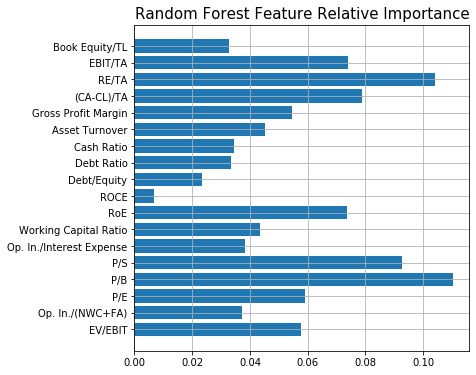

In [315]:
plt.figure(figsize=(6,6))
plt.barh(ks,scores)
plt.grid()
plt.title('Random Forest Feature Relative Importance',fontsize=15)

# Gradient Boosted Decision Tree Regressor

In [316]:
# Read in data and do train/test split.
from sklearn.model_selection import train_test_split
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
y=y["Perf"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
print('X training matrix dimensions: ', X_train.shape)
print('X testing matrix dimensions: ', X_test.shape)
print('y training matrix dimensions: ', y_train.shape)
print('y testing matrix dimensions: ', y_test.shape)

X training matrix dimensions:  (10879, 18)
X testing matrix dimensions:  (1209, 18)
y training matrix dimensions:  (10879,)
y testing matrix dimensions:  (1209,)


In [317]:
from sklearn.ensemble import GradientBoostingRegressor

pl_GradBregressor = Pipeline([
    ('GradBoostRegressor', GradientBoostingRegressor(n_estimators=100,\
                                                     learning_rate=0.1,\
                                                     max_depth=10,\
                                                     random_state=42,\
                                                     loss='ls'))\
])

pl_GradBregressor.fit(X_train, y_train)
y_pred = pl_GradBregressor.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, pl_GradBregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))

import pickle
pickle.dump(pl_GradBregressor, open("pl_GradBregressor.p", "wb" ))

train mse:  0.0389017990379081
test mse:  0.2572710292117676


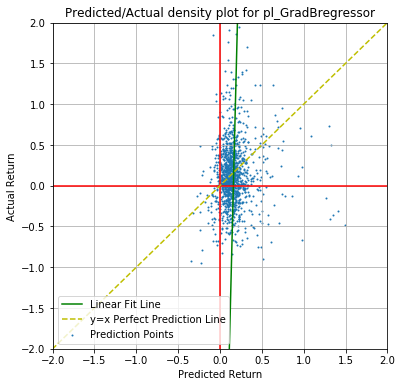

In [323]:
plt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_GradBregressor', y_pred, y_test.to_numpy(),2)

In [319]:
# See top 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_top10 = (y_predtest[0] > y_predtest.nlargest(10,0).tail(1)[0].values[0])
y_test_reindexed=y_test.reset_index(drop=True)

#print('Returns:',y_predtest[bl_top10][0].values)
print('Top 10 Predicted Returns:', round( np.mean(y_predtest[bl_top10][0])*100,2 ), '%','\n')
#print('Returns:', y_test_reindexed[bl_top10].values)
print('Actual Top 10 Returns:', round( np.mean(y_test_reindexed[bl_top10])*100,2 ), '%','\n')

# See bottom 10 stocks and see how the values differ
y_predtest=pd.DataFrame(y_pred)
bl_bottom10 = (y_predtest[0] < y_predtest.nsmallest(10,0).tail(1)[0].values[0])

#print('Returns:',y_predtest[bl_bottom10][0].values)
print('Bottom 10 Predicted Returns:', round( np.mean(y_predtest[bl_bottom10][0])*100,2 ), '%','\n')
#print('Returns:',y_test_reindexed[bl_bottom10].values)
print('Actual Bottom 10 Returns:', round( np.mean(y_test_reindexed[bl_bottom10])*100,2 ), '%')

Top 10 Predicted Returns: 167.1 % 

Actual Top 10 Returns: 23.5 % 

Bottom 10 Predicted Returns: -26.01 % 

Actual Bottom 10 Returns: -39.9 %


In [320]:
observePredictionAbility(pl_GradBregressor)

Predicted Performance of Top 10 Return Portfolios: [240.64 291.97 164.32 484.44 327.85 380.33 140.7  168.95 196.33 200.18]
Actual Performance of Top 10 Return Portfolios: [ 23.81  99.83  43.93  55.88  -5.88  97.46  62.79  31.72  34.29 -29.17] 

Predicted Performance of Bottom 10 Return Portfolios: [-33.66 -29.98 -37.78 -29.04 -20.28 -31.24 -35.32 -25.64 -40.76 -36.6 ]
Actual Performance of Bottom 10 Return Portfolios: [ 26.64  25.98   8.43  10.68  -8.76  -0.79   9.91 -11.41   1.09  60.31]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 104.96
Mean Actual Std. Dev. of Top 10 Return Portfolios: 38.6
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 5.8
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 20.06
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 259.57
Mean Actual Performance of Top 10 Return Portfolios: 41.47
Mean Predicted Performance of Bottom 10 Return Portfolios: -32.03
Mean Actual Performance of Bottom 10 Return Port

# Try a hypothetical company and see the prediction

In [324]:
x.mean()

EV/EBIT                     13.016235
Op. In./(NWC+FA)             0.207207
P/E                         17.381071
P/B                          4.077148
P/S                         13.990528
Op. In./Interest Expense    26.270838
Working Capital Ratio        2.695140
RoE                          0.067662
ROCE                         0.129202
Debt/Equity                  2.387470
Debt Ratio                   2.715851
Cash Ratio                   1.365028
Asset Turnover              31.623771
Gross Profit Margin          0.467918
(CA-CL)/TA                   0.220722
RE/TA                       -0.243144
EBIT/TA                      0.039994
Book Equity/TL               1.662915
dtype: float64

In [325]:
y.mean()

0.1547043809519322

In [326]:
# Put in a dataframe for prediction
avg_company = pd.DataFrame(x.mean().values.reshape(1,-1), columns=x.keys())

In [327]:
rfregressor.predict(avg_company)

array([0.13582227])

In [332]:
# Try making a bunch of numbers reflect higher earnings relative to price
avg_company['EV/EBIT']=7
avg_company['Op. In./(NWC+FA)']=0.5
avg_company['P/E']=9
avg_company['P/B']=3
avg_company['P/S']=5
avg_company['Op. In./Interest Expense']=50
avg_company['EBIT/TA']=0.7

rfregressor.predict(avg_company)

array([0.19454374])

In [ ]:
# That's a great return, I might buy that stock!